In [1]:
# Тестирование нейросети через REST API для детекции дефектов дорожного полотна
import requests
import base64
import json
import numpy as np
import cv2
from PIL import Image
import io
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# URL API сервера
API_URL = "http://localhost:8080/api/v1/test/detect"


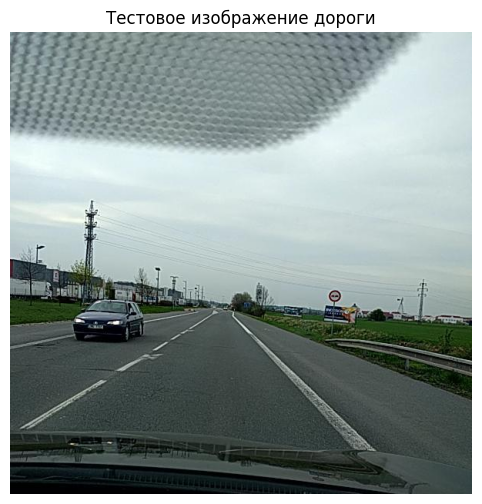

Тестовое изображение создано: (600, 600, 3)


In [2]:

# test_image_path = "test_images/ty06city-BADROAD6jpg.jpeg"
# test_image_path = "test_images/01.png"
test_image_path ="test_images/Czech_002942.jpg"
# test_image_path ="test_images/China_MotorBike_001236.jpg"

# читаем картинку как массив
img = cv2.imread(test_image_path)           # BGR
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 6))
plt.imshow(img_rgb)
plt.title("Тестовое изображение дороги")
plt.axis('off')
plt.show()

print(f"Тестовое изображение создано: {img.shape}")

In [3]:
# Конвертация изображения в base64
def image_to_base64(img_rgb):
    """Конвертирует изображение (numpy array) в base64 строку"""
    # Кодируем изображение в JPEG
    success, encoded_image = cv2.imencode('.jpg', img_rgb)
    if not success:
        raise ValueError("Не удалось закодировать изображение")
    
    # Конвертируем в base64
    image_base64 = base64.b64encode(encoded_image.tobytes()).decode('utf-8')
    return image_base64

# Конвертируем тестовое изображение
image_base64 = image_to_base64(img_rgb)
print(f"Изображение конвертировано в base64 (длина: {len(image_base64)} символов)")


Изображение конвертировано в base64 (длина: 125408 символов)


In [4]:
# Подготовка запроса к API
request_data = {
    "image": image_base64,
    "confidence_threshold": 0.02
}

print("Отправка запроса к API...")
print(f"URL: {API_URL}")
print(f"Confidence threshold: {request_data['confidence_threshold']}")

# Отправка POST запроса
try:
    response = requests.post(
        API_URL,
        json=request_data,
        headers={"Content-Type": "application/json"},
        timeout=10
    )
    
    # Проверка статуса ответа
    response.raise_for_status()
    
    # Получение результата
    result = response.json()
    
    print(f"Запрос успешен! Статус: {response.status_code}")
    print(f"\nРезультаты детекции:")
    print(f"  - Успех: {result['success']}")
    print(f"  - Время обработки: {result['processing_time_ms']} мс")
    print(f"  - Размер изображения: {result['image_shape']}")
    print(f"  - Обнаружено дефектов: {len(result['detections'])}")
    print(f"  - Сообщение: {result['message']}")
    
    if result['detections']:
        print(f"\nДетали детекций:")
        for i, det in enumerate(result['detections'], 1):
            print(f"  {i}. {det['class_name']} (ID: {det['class_id']})")
            print(f"     - Уверенность: {det['confidence']:.2%}")
            print(f"     - BBox: {det['bbox']}")
    
except requests.exceptions.ConnectionError:
    print("Ошибка: Не удалось подключиться к API серверу")
    print("   Убедитесь, что сервер запущен: python main.py")
except requests.exceptions.Timeout:
    print("Ошибка: Превышено время ожидания ответа")
except requests.exceptions.HTTPError as e:
    print(f"HTTP ошибка: {e}")
    print(f"   Ответ сервера: {response.text}")
except Exception as e:
    print(f"Неожиданная ошибка: {e}")
    import traceback
    traceback.print_exc()


Отправка запроса к API...
URL: http://localhost:8080/api/v1/test/detect
Confidence threshold: 0.02
Запрос успешен! Статус: 200

Результаты детекции:
  - Успех: True
  - Время обработки: 430.39 мс
  - Размер изображения: [600, 600, 3]
  - Обнаружено дефектов: 9
  - Сообщение: Обнаружено дефектов: 9

Детали детекций:
  1. D00 (ID: 0)
     - Уверенность: 60.39%
     - BBox: [172.30592346191406, 429.1692199707031, 212.83184814453125, 486.31549072265625]
  2. D10 (ID: 1)
     - Уверенность: 39.90%
     - BBox: [2.039808988571167, 419.49993896484375, 189.8760986328125, 453.9974365234375]
  3. D10 (ID: 1)
     - Уверенность: 27.65%
     - BBox: [84.15982818603516, 428.6568603515625, 188.29336547851562, 449.8647155761719]
  4. D10 (ID: 1)
     - Уверенность: 17.39%
     - BBox: [0.0, 412.43035888671875, 196.59381103515625, 459.79083251953125]
  5. D10 (ID: 1)
     - Уверенность: 8.95%
     - BBox: [38.49053955078125, 423.63671875, 197.2777557373047, 453.618408203125]
  6. D10 (ID: 1)
     - Ув

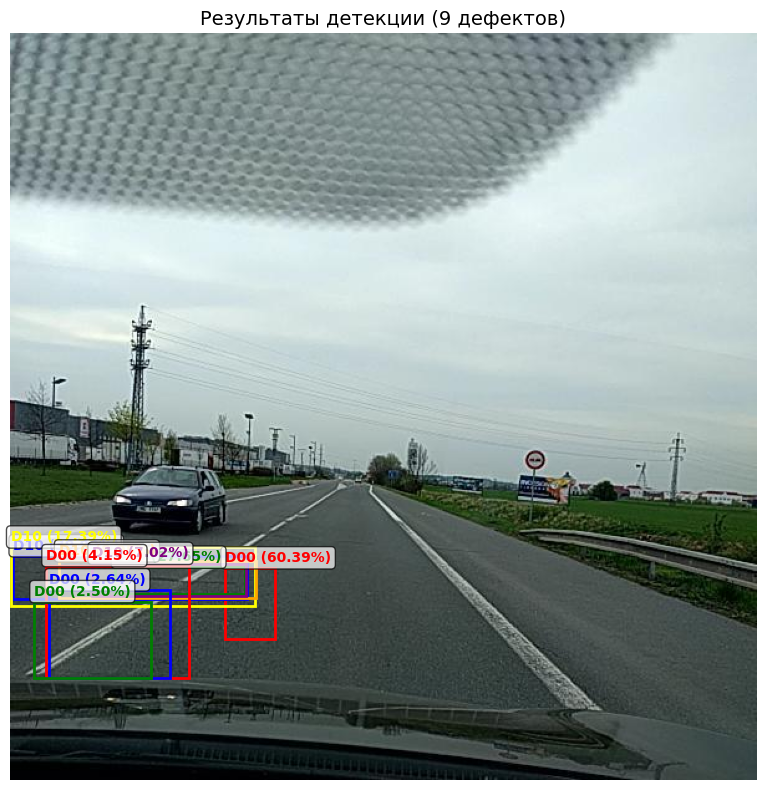

Готово


In [5]:
# Визуализация результатов детекции
if 'result' in locals() and result['success'] and result['detections']:
    
    # Создаём фигуру
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.imshow(img_rgb)
    ax.set_title(f"Результаты детекции ({len(result['detections'])} дефектов)", fontsize=14)
    ax.axis('off')
    
    # Рисуем bounding boxes
    colors = ['red', 'blue', 'green', 'yellow', 'orange', 'purple']
    for i, det in enumerate(result['detections']):
        bbox = det['bbox']
        x_min, y_min, x_max, y_max = bbox
        
        # Создаём прямоугольник
        rect = Rectangle(
            (x_min, y_min),
            x_max - x_min,
            y_max - y_min,
            linewidth=2,
            edgecolor=colors[i % len(colors)],
            facecolor='none'
        )
        ax.add_patch(rect)
        
        # Добавляем подпись
        label = f"{det['class_name']} ({det['confidence']:.2%})"
        ax.text(
            x_min, y_min - 5,
            label,
            color=colors[i % len(colors)],
            fontsize=10,
            weight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7)
        )
    
    plt.tight_layout()
    plt.show()
    
    print("Готово")
else:
    print("Нет данных для визуализации")
